# Olfactory Transduction Library

In this notebook, we demonstrate the various ways that the `Olftrans` package is to be consumed by end-users.

### Table of Content

1. [Estimating Binding & Dissociation Rate From Data (_Main Entry Point_)](#estimate_bd)
2. [Computing Resting Spike Rate of BSG](#compute_resting)
3. [Computing F-I curve of BSG](#compute_fi)
4. [Computing Peak and Stead-State Output of OTP under Step Input](#compute_peak_ss_I)
5. [Computing Peak and Stead-State Output of OTP-BSG under Step Input](#compute_peak_ss_spike)
6. [Working with other FlyBrainLab Packages](#fbl)

In [24]:
import os
import matplotlib.pyplot as plt
import numpy as np

<a id="estimate_bd"></a>
# 1. Estimating Binding & Dissociation Rates from Data

In this section, we show an example of estimating binding and dissociation rates from spike rate data.
The data that we will use is from Hallem & Carlson 2006. The data shows the steady-state spike rates 
of odorant-receptor pairs under a step concentration input of 100 ppm.

The processed data is available in the `Olftrans` package as `olftrans.data.HallemCarlson.DATA`.


### Assumptions and Data Pre-processing
1. Steady-State Response Assumption:
    - Note that from the original 2006 publication's _Experimental Procedure_ Section:
        > Responses were quantified by subtracting the number of impulses in 500 ms of unstimulated activity from the number of impulses in the 500 ms following odorant stimulation, unless otherwise indicated.

      We assume that 500 ms is sufficient for the response to reach steady-state. 

2. Response level calculation:
    - Note that from the original 2006 publication's _Figure 1 Caption_:
        > Responses of each receptor to the diluent were subtracted from each odorant response
       
      To take into account the spontaneous firing rate of OSNs expressing each receptor type, we add the spontaneous firing rate to the reported spike rate by Hallem & Carlson. Note that this is consistent with the procedure in _Stevens 2016 PNAS_
      
3. Negative Spike Rate:
    - Even after adding the spontaneous firing rates, some of the firing rates are still negative. As such, we recify the resulting spike rate to be non-negative. Note that this is consistent with the procedure in _Stevens 2016 PNAS_

In [25]:
from olftrans import olftrans
from olftrans import data

In [26]:
data.HallemCarlson.DATA

OR,2a,7a,9a,10a,19a,22a,23a,33b,35a,43a,...,59b,65a,67a,67c,82a,85a,85b,85f,88a,98a
ammonium hydroxide,11,0,35,24,30,17,7,16,21,20,...,7,21,27,16,18,8,28,24,26,36
putrescine,14,0,29,0,20,16,7,21,17,4,...,4,16,7,12,12,1,37,15,20,29
cadaverine,9,0,24,0,24,17,2,18,29,11,...,9,17,3,20,14,3,42,23,26,33
g-butyrolactone,17,51,56,8,22,47,13,32,98,9,...,18,24,136,26,9,6,60,30,28,41
g-hexalactone,23,0,121,32,27,144,21,50,188,29,...,20,36,58,46,21,11,66,61,29,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ethyl decanoate,13,5,5,57,12,10,8,26,7,13,...,5,14,4,3,12,0,41,5,21,24
ethyl trans-2-butenoate,19,15,106,160,38,214,18,21,31,0,...,0,20,115,40,32,105,93,31,17,255
ethyl lactate,47,48,78,45,53,74,20,27,22,28,...,135,49,50,294,58,53,90,84,19,78
diethyl succinate,24,6,24,1,53,209,35,17,0,13,...,0,23,186,13,48,2,48,19,31,16


We can then calculate the affinity values of the odorant-receptor pairs based on the data.

In [27]:
spike_rates = data.HallemCarlson.DATA[~data.HallemCarlson.DATA.isna()].values
hallem_carlson_est = olftrans.estimate(amplitude=100., resting_spike_rate=8., steady_state_spike_rate=spike_rates, decay_time=0.1)

/mnt/server-home/tingkai/Project/FBL/olftrans/olftrans/olftrans.py:205: RuntimeWarning: invalid value encountered in power
  res = np.atleast_1d(np.power(c * (y - b) / (a - (y - b)), 1.0 / n))


The estimation result `hallem_carlson_est` is a `dataclass` that contains estimated affinity values in `hallem_carlson_est.affs` attribute.
We can save the estimated affinity values into another dataframe as follows.

In [28]:
hallem_carlson_affs = data.HallemCarlson.DATA.copy()
hallem_carlson_affs[~hallem_carlson_affs.isna()] = hallem_carlson_est.affs
hallem_carlson_affs

OR,2a,7a,9a,10a,19a,22a,23a,33b,35a,43a,...,59b,65a,67a,67c,82a,85a,85b,85f,88a,98a
ammonium hydroxide,1.156723e-04,1.000000e-08,2.094772e-03,9.766312e-04,0.001503,5.212538e-04,1.000000e-08,0.000443,8.016210e-04,7.467411e-04,...,1.000000e-08,0.000802,1.209416e-03,4.432747e-04,0.000604,1.000000e-08,0.001302,9.766312e-04,0.001120,0.002195
putrescine,3.017768e-04,1.000000e-08,1.399456e-03,1.000000e-08,0.000747,4.432747e-04,1.000000e-08,0.000802,5.212538e-04,1.000000e-08,...,1.000000e-08,0.000443,1.000000e-08,1.767932e-04,0.000177,1.000000e-08,0.002298,3.701777e-04,0.000747,0.001399
cadaverine,1.071634e-05,1.000000e-08,9.766312e-04,1.000000e-08,0.000977,5.212538e-04,1.000000e-08,0.000604,1.399456e-03,1.156723e-04,...,1.071634e-05,0.000521,1.000000e-08,7.467411e-04,0.000302,1.000000e-08,0.002887,9.165148e-04,0.001120,0.001867
g-butyrolactone,5.212538e-04,4.479508e-03,5.779083e-03,1.000000e-08,0.000858,3.651085e-03,2.372978e-04,0.001740,1.000000e+01,1.071634e-05,...,6.035361e-04,0.000977,1.000000e+01,1.120098e-03,0.000011,1.000000e-08,0.006760,1.502852e-03,0.001302,0.002757
g-hexalactone,9.165148e-04,1.000000e-08,1.000000e+01,1.740122e-03,0.001209,1.000000e+01,8.016210e-04,0.004255,1.000000e+01,1.399456e-03,...,7.467411e-04,0.002195,6.247649e-03,3.468435e-03,0.000802,1.156723e-04,0.009254,7.034142e-03,0.001399,0.002195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ethyl decanoate,2.372978e-04,1.000000e-08,1.000000e-08,6.008248e-03,0.000177,5.923248e-05,1.000000e-08,0.001120,1.000000e-08,2.372978e-04,...,1.000000e-08,0.000302,1.000000e-08,1.000000e-08,0.000177,1.000000e-08,0.002757,1.000000e-08,0.000802,0.000977
ethyl trans-2-butenoate,6.902767e-04,3.701777e-04,1.000000e+01,1.000000e+01,0.002405,1.000000e+01,6.035361e-04,0.000802,1.618735e-03,1.000000e-08,...,1.000000e-08,0.000747,1.000000e+01,2.631663e-03,0.001740,1.000000e+01,0.125560,1.618735e-03,0.000521,10.000000
ethyl lactate,3.651085e-03,3.842621e-03,1.828008e-02,3.307855e-03,0.004974,1.408008e-02,7.467411e-04,0.001209,8.581957e-04,1.302476e-03,...,1.000000e+01,0.004044,4.254832e-03,1.000000e+01,0.006248,4.974074e-03,0.063179,3.236807e-02,0.000690,0.018280
diethyl succinate,9.766312e-04,1.000000e-08,9.766312e-04,1.000000e-08,0.004974,1.000000e+01,2.094772e-03,0.000521,1.000000e-08,2.372978e-04,...,1.000000e-08,0.000917,1.000000e+01,2.372978e-04,0.003843,1.000000e-08,0.003843,6.902767e-04,0.001619,0.000443


Note that since peak response was not reported in Hallem&Carlson 2006, we cannot estimate dissociation rate directly.
However, the dissociation rate is the reciprocal of the decay time for the OSN activity to settle from steady-state response to resting response after odorant offset. 

Assuming that the `decay_time` is 100 ms, the dissociation rate should be $10 s^{-1}$, which is the value given in `hallem_carlson_est.dr`.

<a id="compute_resting"></a>
# 2. Computing Resting Spike Rate of BSG

OSNs are spontaneously firing neurons whose spiking mechanism is modeled by a ConnorStevens neuron model with noisy state values. The state parameters are perturbed by a brownian motion whose standard deviation value `sigma` controls the resting spike rate of the neuron. 

Given the Connor-Stevens neuron model, we can fix all other parameters except for `sigma` and vary `sigma` to obtain the resting spike rate. This `sigma`-spike rate relationship can then be used to estimate the `sigma` parameter given resting spike rates.

In [38]:
from olftrans.neurodriver import model as nd

dt = 1e-5
repeat = 50
sigmas = np.linspace(0,0.007,100)
_, rest_fs = nd.compute_resting(
    nd.NoisyConnorStevens, 'sigma', sigmas/np.sqrt(dt), dt=dt, dur=2.,
    repeat=repeat, save=True, smoothen=True, savgol_window=31, savgol_order=4
)

Resting Spike Rate NoisyConnorStevens - Against sigma: Number of NoisyConnorStevens: 5000
Resting Spike Rate NoisyConnorStevens - Against sigma: Number of Input: {'I': 5000}


Resting Spike Rate NoisyConnorStevens - Against sigma:   0%|          | 973/200000 [00:00<00:20, 9726.11it/s]

Compilation of executable circuit completed in 0.9522390365600586 seconds


Resting Spike Rate NoisyConnorStevens - Against sigma: 100%|██████████| 200000/200000 [00:26<00:00, 7635.25it/s]


In [39]:
target_resting_rate = 8. # Hz
target_sigma = np.interp(target_resting_rate, xp=rest_fs, fp=sigmas)

Text(0, 0.5, 'Spike Rate [$Hz$]')

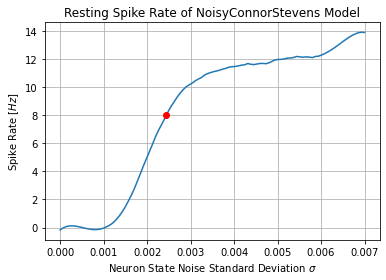

In [40]:
%matplotlib inline
plt.figure()
plt.plot(sigmas, rest_fs)
plt.plot(target_sigma, target_resting_rate, 'ro')
plt.grid()
plt.title('Resting Spike Rate of NoisyConnorStevens Model')
plt.xlabel('Neuron State Noise Standard Deviation $\sigma$')
plt.ylabel('Spike Rate [$Hz$]')

<a id="compute_fi"/>

# 3. Computing BSG F-I Curve

Once a `sigma` value is found for a BSG neuron, we can then find the Frequency-Current curve of a given neuron model. Obtaining the F-I curve will help us estimate the OTP output current from the OSN's output spike rate.

In [41]:
from olftrans import data

In [42]:
from olftrans.neurodriver import model as nd

dt = 1e-5
repeat = 50
Is = np.linspace(0,150,150)
sigma = 0.0024413599558694506
_, fs = nd.compute_fi(
    nd.NoisyConnorStevens, Is, dt=dt, dur=3., 
    repeat=repeat, save=True,
    neuron_params={'sigma':sigma/np.sqrt(dt)}
)

F-I NoisyConnorStevens: Number of NoisyConnorStevens: 7500
F-I NoisyConnorStevens: Number of Input: {'I': 7500}


F-I NoisyConnorStevens:   0%|          | 971/300000 [00:00<00:30, 9708.94it/s]

Compilation of executable circuit completed in 1.1393799781799316 seconds


F-I NoisyConnorStevens: 100%|██████████| 300000/300000 [00:44<00:00, 6670.95it/s]


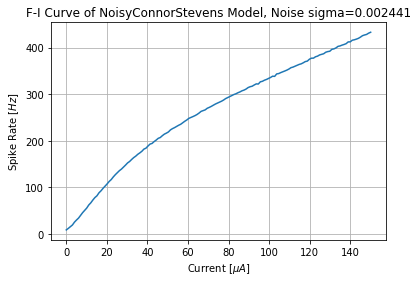

In [43]:
%matplotlib inline
plt.figure()
plt.plot(Is, fs)
plt.grid()
plt.title(f'F-I Curve of NoisyConnorStevens Model, Noise sigma={sigma:.6f}')
plt.xlabel('Current [$\mu A$]')
plt.ylabel('Spike Rate [$Hz$]')
plt.show()

<a id="compute_peak_ss_I"/> 

# 4. Computing Peak and Steady State Response of OTP

Once the F-I curve is found, it can be used to estimate the output current of OTP model to give rise to the observed spike rate at the output of OSN Axon-Hillock.

In [32]:
import os
import matplotlib.pyplot as plt
import numpy as np
from olftrans.neurodriver import model as nd

dt = 1e-5
brs = 10**np.linspace(-2, 4, 100)
drs = 10**np.linspace(-2, 4, 100)
amplitude = 100.
_,_,I_ss,I_peak = nd.compute_peak_ss_I(brs, drs, dt=dt, dur=4., start=0.5, save=True, amplitude=amplitude)

OTP Currents: Number of OTP: 10000
OTP Currents: Number of Input: {'conc': 10000}


OTP Currents:   0%|          | 1000/400000 [00:00<00:50, 7926.57it/s]

Compilation of executable circuit completed in 0.8145713806152344 seconds


OTP Currents: 100%|██████████| 400000/400000 [01:03<00:00, 6272.69it/s]


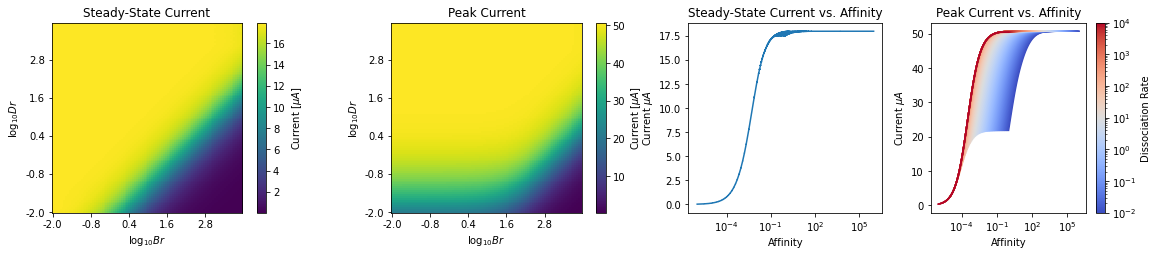

In [33]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import ticker

fig, axes = plt.subplots(1,4,figsize=(20,3.5), gridspec_kw={'width_ratios':[1.5,1.5,1,1]})
cax = axes[0].imshow(I_ss, origin='lower', interpolation='none')
plt.colorbar(cax, ax=axes[0], label='Current [$\mu A$]')
axes[0].set_title('Steady-State Current')
cax = axes[1].imshow(I_peak, origin='lower', interpolation='none')
plt.colorbar(cax, ax=axes[1], label='Current [$\mu A$]')
axes[1].set_title('Peak Current')
@ticker.FuncFormatter
def x_formatter(x, pos):
    _x = np.interp(x, xp=np.arange(len(brs)), fp=brs)
    return f"{np.log10(_x):.1f}"

@ticker.FuncFormatter
def y_formatter(x, pos):
    _x = np.interp(x, xp=np.arange(len(drs)), fp=drs)
    return f"{np.log10(_x):.1f}"

axes[0].xaxis.set_major_formatter(x_formatter)
axes[0].yaxis.set_major_formatter(y_formatter)
axes[1].xaxis.set_major_formatter(x_formatter)
axes[1].yaxis.set_major_formatter(y_formatter)
axes[0].set_xlabel('$\log_{10}Br$')
axes[0].set_ylabel('$\log_{10}Dr$')
axes[1].set_xlabel('$\log_{10}Br$')
axes[1].set_ylabel('$\log_{10}Dr$')

DR,BR = np.meshgrid(drs, brs)
affs = (BR/DR).ravel()

I_ss_flat = I_ss.ravel()
idx = np.argsort(affs)
axes[2].semilogx(affs[idx], I_ss_flat[idx])
axes[2].set_title('Steady-State Current vs. Affinity')
axes[2].set_xlabel('Affinity')
axes[2].set_ylabel('Current $\mu A$')

colors = plt.cm.get_cmap('coolwarm', len(drs))
for n_d, d in enumerate(drs):
    axes[3].semilogx((BR/DR)[:,n_d], I_peak[:,n_d], '-', c=colors(n_d))
axes[3].set_title('Peak Current vs. Affinity')
axes[3].set_xlabel('Affinity')
axes[3].set_ylabel('Current $\mu A$')

norm = mpl.colors.LogNorm(vmin=drs.min(), vmax=drs.max())
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.coolwarm),
             ax=axes[3], orientation='vertical', label='Dissociation Rate')
fig.show()

## 4.1 Infer Mapping from Affinity -> Steady-State Spike-Rate

From steady-state spike rate, the affinity value can be estimated either by data interpolation _or_ parametrically by first fitting a function to the spike-rate vs. affinity relationship.

Note that this can only be done robustly for the steady-state vs. affinity relationship (and not the other relationships above) because data reveals that such relationship strongly resembles a hill function.

As such, we use Differential Evolution to first estimate the parameter of a hill function that maps affinity value to steady-state output current of OTP and use the inverse of this function to estimate the affinity value from a given steady-state OTP current.

**Note**: Because the steady-state current of OTP model follows a hill function shape, it is _nonnegative_ and _saturates_ at a finite value. For steady-state currents outside of this range, the input affinity value cannote be estimated. As such, we clip the steady-state current value to be between the supported range beforing estimating its associated affinity value.

In [75]:
from scipy.optimize import differential_evolution

In [76]:
affs_intp = 10**np.linspace(-6,3,1000)
I_ss_flat = I_ss.ravel()
idx = np.argsort(affs)
ss_intp = np.interp(affs_intp, affs[idx], I_ss_flat[idx])
hill_f = lambda x, a,b,c,n: b + a*x**n/(x**n+c)
def cost(x, aff, ss):
    a,b,c,n = x
    pred = hill_f(aff,a,b,c,n)
    return np.linalg.norm(pred-ss)
bounds = [(0,100), (0, 100), (0,100), (.5, 2.)]
diffeq_ss = differential_evolution(cost, bounds, tol=1e-4, args=(affs_intp, ss_intp), disp=False)

In [36]:
def inverse_hill_f(y,a,b,c,n, x_ref):
    res = np.power(c*(y-b)/(a-(y-b)), 1./n)
    res[y<b] = x_ref.min()
    res[(y-b) > a] = x_ref.max()
    return res

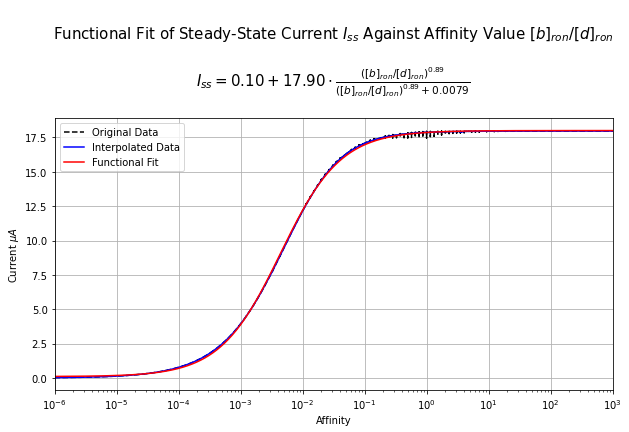

In [37]:
a,b,c,n = diffeq_ss.x
plt.figure(figsize=(10,5))
plt.semilogx(affs[idx], I_ss_flat[idx], '--k',label='Original Data')
plt.semilogx(affs_intp, ss_intp, '-b',label='Interpolated Data')
plt.semilogx(affs_intp, hill_f(affs_intp, *diffeq_ss.x), '-r',label='Functional Fit')
plt.grid()
plt.legend()
plt.xlabel('Affinity')
plt.ylabel('Current $\mu A$')
plt.title(f'''
Functional Fit of Steady-State Current $I_{{ss}}$ Against Affinity Value $[b]_{{ron}}/[d]_{{ron}}$ \n
$I_{{ss}} = {b:.2f} + {a:.2f}\\cdot\\frac{{([b]_{{ron}}/[d]_{{ron}})^{{{n:.2f}}}}}{{([b]_{{ron}}/[d]_{{ron}})^{{{n:.2f}}} + {c:.4f}}}$
''', fontsize=15)
plt.xlim([1e-6, 1e3])
fig.show()

<a id="compute_peak_ss_spike" />

# 5. Computing Peak and Steady State Response of OTP-BSG Cascade

Instead of going from `Spike Rates -> Current -> Affinity`, we can also go directly from `Spike Rate -> Affininty`. To do this, we will need to estimate the spike rate of the OTP-BSG cascade under step input waveform.

**Note**: because of the complexity of this estimation task, the code below takes significantly longer to run.

In [30]:
import os
import matplotlib.pyplot as plt
import numpy as np
from olftrans.neurodriver import model as nd

dt = 8e-6
brs = 10**np.linspace(-2, 4, 50)
drs = 10**np.linspace(-2, 4, 50)
repeat = 30
amplitude = 100.
_,_,I_ss,I_peak,f_ss,f_peak = nd.compute_peak_ss_spike_rate(brs, drs, dt=dt, dur=3., start=0.5, repeat=repeat, save=False, amplitude=amplitude)

OTP-BSG Peak vs. SS: Number of OTP: 2500
OTP-BSG Peak vs. SS: Number of NoisyConnorStevens: 75000
OTP-BSG Peak vs. SS: Number of Input: {'conc': 2500}


OTP-BSG Peak vs. SS:   0%|          | 790/375000 [00:00<00:47, 7895.87it/s]

Compilation of executable circuit completed in 3.95257306098938 seconds


Computing PSTH...:   0%|          | 0/2500 [00:00<?, ?it/s]

Computing Peak and Steady State Currents
Computing Peak and Steady State Spike Rates


Computing PSTH...: 100%|██████████| 2500/2500 [16:09<00:00,  2.58it/s]


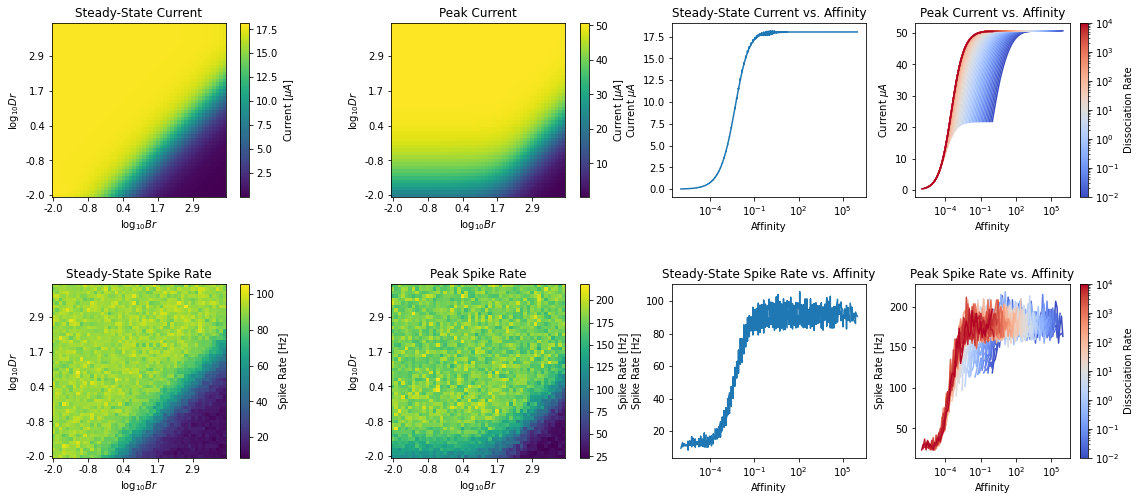

In [37]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import ticker

fig, axes = plt.subplots(2,4,figsize=(20,8), gridspec_kw={'width_ratios':[1.5,1.5,1,1], 'hspace': .5})
cax = axes[0,0].imshow(I_ss, origin='lower', interpolation='none')
plt.colorbar(cax, ax=axes[0,0], label='Current [$\mu A$]')
axes[0,0].set_title('Steady-State Current')
cax = axes[0,1].imshow(I_peak, origin='lower', interpolation='none')
plt.colorbar(cax, ax=axes[0,1], label='Current [$\mu A$]')
axes[0,1].set_title('Peak Current')
@ticker.FuncFormatter
def x_formatter(x, pos):
    _x = np.interp(x, xp=np.arange(len(brs)), fp=brs)
    return f"{np.log10(_x):.1f}"

@ticker.FuncFormatter
def y_formatter(x, pos):
    _x = np.interp(x, xp=np.arange(len(drs)), fp=drs)
    return f"{np.log10(_x):.1f}"

axes[0,0].xaxis.set_major_formatter(x_formatter)
axes[0,0].yaxis.set_major_formatter(y_formatter)
axes[0,1].xaxis.set_major_formatter(x_formatter)
axes[0,1].yaxis.set_major_formatter(y_formatter)
axes[0,0].set_xlabel('$\log_{10}Br$')
axes[0,0].set_ylabel('$\log_{10}Dr$')
axes[0,1].set_xlabel('$\log_{10}Br$')
axes[0,1].set_ylabel('$\log_{10}Dr$')

DR,BR = np.meshgrid(drs, brs)
affs = (BR/DR).ravel()

I_ss_flat = I_ss.ravel()
idx = np.argsort(affs)
axes[0,2].semilogx(affs[idx], I_ss_flat[idx])
axes[0,2].set_title('Steady-State Current vs. Affinity')
axes[0,2].set_xlabel('Affinity')
axes[0,2].set_ylabel('Current $\mu A$')

colors = plt.cm.get_cmap('coolwarm', len(drs))
for n_d, d in enumerate(drs):
    axes[0,3].semilogx((BR/DR)[:,n_d], I_peak[:,n_d], '-', c=colors(n_d))
axes[0,3].set_title('Peak Current vs. Affinity')
axes[0,3].set_xlabel('Affinity')
axes[0,3].set_ylabel('Current $\mu A$')

norm = mpl.colors.LogNorm(vmin=drs.min(), vmax=drs.max())
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.coolwarm),
             ax=axes[0,3], orientation='vertical', label='Dissociation Rate')


# Frequencies
cax = axes[1,0].imshow(f_ss, origin='lower', interpolation='none')
plt.colorbar(cax, ax=axes[1,0], label='Spike Rate [Hz]')
axes[1,0].set_title('Steady-State Spike Rate')
cax = axes[1,1].imshow(f_peak, origin='lower', interpolation='none')
plt.colorbar(cax, ax=axes[1,1], label='Spike Rate [Hz]')
axes[1,1].set_title('Peak Spike Rate')
@ticker.FuncFormatter
def x_formatter(x, pos):
    _x = np.interp(x, xp=np.arange(len(brs)), fp=brs)
    return f"{np.log10(_x):.1f}"

@ticker.FuncFormatter
def y_formatter(x, pos):
    _x = np.interp(x, xp=np.arange(len(drs)), fp=drs)
    return f"{np.log10(_x):.1f}"

axes[1,0].xaxis.set_major_formatter(x_formatter)
axes[1,0].yaxis.set_major_formatter(y_formatter)
axes[1,1].xaxis.set_major_formatter(x_formatter)
axes[1,1].yaxis.set_major_formatter(y_formatter)
axes[1,0].set_xlabel('$\log_{10}Br$')
axes[1,0].set_ylabel('$\log_{10}Dr$')
axes[1,1].set_xlabel('$\log_{10}Br$')
axes[1,1].set_ylabel('$\log_{10}Dr$')

DR,BR = np.meshgrid(drs, brs)
affs = (BR/DR).ravel()

f_ss_flat = f_ss.ravel()
idx = np.argsort(affs)
axes[1,2].semilogx(affs[idx], f_ss_flat[idx])
axes[1,2].set_title('Steady-State Spike Rate vs. Affinity')
axes[1,2].set_xlabel('Affinity')
axes[1,2].set_ylabel('Spike Rate [Hz]')

colors = plt.cm.get_cmap('coolwarm', len(drs))
for n_d, d in enumerate(drs):
    axes[1,3].semilogx((BR/DR)[:,n_d], f_peak[:,n_d], '-', c=colors(n_d))
axes[1,3].set_title('Peak Spike Rate vs. Affinity')
axes[1,3].set_xlabel('Affinity')
axes[1,3].set_ylabel('Spike Rate [Hz]')

norm = mpl.colors.LogNorm(vmin=drs.min(), vmax=drs.max())
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.coolwarm),
             ax=axes[1,3], orientation='vertical', label='Dissociation Rate')
fig.show()

<a id="fbl"/>

# 6. Working with Other FBL Packages

`OlfTrans` is intended to be used in conjuction with other FBL packages. To make `OlfTrans` compatible with other executable circuits, we define an `olftrans.fbl` module that exposes a class `olftrans.fbl.FBL` that has the following attributes (among others, see documentation for further details):

1. `graph`: a `networkx.MultiDiGraph` instance that defines the executable circuit comprised of OTP-BSG cascades
2. `inputs`: a dictionary of form `{var: uids}` that define the input variables and input nodes of the graph
3. `outputs`: a dictionary of form `{var: uids}` that define the output variables and output nodes of the graph

Additionally, we provide 2 pre-computed `FBL` instances using _Drosophila_ larva and adult data respectively:

1. `olftrans.fbl.LARVA`: `FBL` instance using data from _Kreher et al. 2005_
2. `olftrans.fbl.Adult`: `FBL` instance using data from _Hallem & Carlson. 2006_

In [20]:
from olftrans import fbl

/mnt/server-home/tingkai/Project/FBL/olftrans/olftrans/olftrans.py:205: RuntimeWarning: invalid value encountered in power
  res = np.atleast_1d(np.power(c * (y - b) / (a - (y - b)), 1.0 / n))
/mnt/server-home/tingkai/Project/FBL/olftrans/olftrans/olftrans.py:205: RuntimeWarning: invalid value encountered in power
  res = np.atleast_1d(np.power(c * (y - b) / (a - (y - b)), 1.0 / n))


In [21]:
fbl.LARVA.config

Config(NR=21, NO=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), affs=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), drs=array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10.]), receptor_names=['Or0', 'Or1', 'Or2', 'Or3', 'Or4', 'Or5', 'Or6', 'Or7', 'Or8', 'Or9', 'Or10', 'Or11', 'Or12', 'Or13', 'Or14', 'Or15', 'Or16', 'Or17', 'Or18', 'Or19', 'Or20'], resting=8.0, sigma=0.002442364106413095)

In [22]:
fbl.LARVA.graph

In [4]:
fbl.LARVA.affinities

OR,30a,42a,45a,45b,49a,69a,67b,74a,85c,94a,94b
ethyl acetate,7.020063e-04,10.000000,0.006268,9.020325e-04,9.020325e-04,5.552458e-03,0.002068,0.003037,5.981671e-03,0.001205,1.316167e-03
pentyl acetate,7.020063e-04,0.021569,10.000000,1.433489e-03,3.384421e-03,2.187482e-03,10.000000,0.005710,1.000000e+01,0.003121,3.823869e-03
ethyl butyrate,5.026630e-04,10.000000,0.009520,7.338427e-04,1.316167e-03,1.496080e-03,0.000799,0.003295,2.156908e-02,0.001048,1.782114e-03
methyl salicylate,2.187482e-03,0.005213,0.000974,1.384997e-04,2.482123e-04,1.204509e-03,0.000368,0.001496,2.797397e-03,0.002068,3.120985e-03
1-hexonol,9.020325e-04,10.000000,10.000000,2.575653e-03,4.064672e-03,1.204509e-03,10.000000,10.000000,1.000000e+01,0.004744,3.206716e-03
1-octen-3-ol,4.560544e-04,0.009823,0.015419,1.937638e-03,3.120985e-03,1.204509e-03,0.012076,0.005844,1.000000e+01,0.002127,2.797397e-03
E2-hexenal,6.005037e-04,10.000000,10.000000,1.259650e-03,1.937638e-03,1.204509e-03,10.000000,10.000000,1.000000e+01,0.001782,1.782114e-03
"2,3-butanedione",6.005037e-04,10.000000,0.004598,1.316167e-03,1.564639e-03,1.496080e-03,0.007227,0.002576,5.005731e-02,0.001496,1.707588e-03
2-heptanone,1.098203e-03,10.000000,10.000000,1.564639e-03,4.190497e-03,2.375506e-03,10.000000,0.264255,1.000000e+01,0.003121,4.743878e-03
geranyl acetate,1.753938e-04,0.008856,0.004895,2.867598e-04,6.518005e-04,3.680727e-04,0.001151,0.002127,4.190497e-03,0.001260,6.518005e-04


In [5]:
fbl.LARVA.inputs

{'conc': array(['OSN-OTP-Or0-O0', 'OSN-OTP-Or1-O0', 'OSN-OTP-Or2-O0',
        'OSN-OTP-Or3-O0', 'OSN-OTP-Or4-O0', 'OSN-OTP-Or5-O0',
        'OSN-OTP-Or6-O0', 'OSN-OTP-Or7-O0', 'OSN-OTP-Or8-O0',
        'OSN-OTP-Or9-O0', 'OSN-OTP-Or10-O0', 'OSN-OTP-Or11-O0',
        'OSN-OTP-Or12-O0', 'OSN-OTP-Or13-O0', 'OSN-OTP-Or14-O0',
        'OSN-OTP-Or15-O0', 'OSN-OTP-Or16-O0', 'OSN-OTP-Or17-O0',
        'OSN-OTP-Or18-O0', 'OSN-OTP-Or19-O0', 'OSN-OTP-Or20-O0'],
       dtype='<U15')}

In [6]:
fbl.LARVA.outputs

{'V': array(['OSN-BSG-Or0-O0', 'OSN-BSG-Or1-O0', 'OSN-BSG-Or2-O0',
        'OSN-BSG-Or3-O0', 'OSN-BSG-Or4-O0', 'OSN-BSG-Or5-O0',
        'OSN-BSG-Or6-O0', 'OSN-BSG-Or7-O0', 'OSN-BSG-Or8-O0',
        'OSN-BSG-Or9-O0', 'OSN-BSG-Or10-O0', 'OSN-BSG-Or11-O0',
        'OSN-BSG-Or12-O0', 'OSN-BSG-Or13-O0', 'OSN-BSG-Or14-O0',
        'OSN-BSG-Or15-O0', 'OSN-BSG-Or16-O0', 'OSN-BSG-Or17-O0',
        'OSN-BSG-Or18-O0', 'OSN-BSG-Or19-O0', 'OSN-BSG-Or20-O0'],
       dtype='<U15'),
 'spike_state': array(['OSN-BSG-Or0-O0', 'OSN-BSG-Or1-O0', 'OSN-BSG-Or2-O0',
        'OSN-BSG-Or3-O0', 'OSN-BSG-Or4-O0', 'OSN-BSG-Or5-O0',
        'OSN-BSG-Or6-O0', 'OSN-BSG-Or7-O0', 'OSN-BSG-Or8-O0',
        'OSN-BSG-Or9-O0', 'OSN-BSG-Or10-O0', 'OSN-BSG-Or11-O0',
        'OSN-BSG-Or12-O0', 'OSN-BSG-Or13-O0', 'OSN-BSG-Or14-O0',
        'OSN-BSG-Or15-O0', 'OSN-BSG-Or16-O0', 'OSN-BSG-Or17-O0',
        'OSN-BSG-Or18-O0', 'OSN-BSG-Or19-O0', 'OSN-BSG-Or20-O0'],
       dtype='<U15')}